# Bridging the Gap

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper, ParityMapper

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

from qiskit_algorithms.optimizers import SPSA, COBYLA, SLSQP

from qiskit_algorithms import VQE

import pylab

from qiskit.primitives import Sampler, Estimator
from qiskit_algorithms.state_fidelities import ComputeUncompute

from qiskit_algorithms import VQD

from qiskit_algorithms import NumPyEigensolver

In [3]:
#molecule = [["atom1", [x, y, z]],["atom2",[x, y, z]...]]
#mapper = JordanWignerMapper(), BravyiKitaevMapper(), ParityMapper()
#ansatz = "UCCSD", "EfficientSU2"
#optimizer = 'spsa', 'cobyla', 'slsqp'

def Bridging_the_Gap(molecule, mapper, ansatz, optimizer):
    
    # building the hamiltonian
    driver = ElectronicStructureMoleculeDriver(Molecule(molecule), basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF) 
    problem = ElectronicStructureProblem(driver)
    second_q_ops = problem.second_q_ops()['ElectronicEnergy']
    print('electrons:',len(problem.num_particles))
    print('orbitals:',int(problem.num_spin_orbitals)) 
    
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(second_q_ops, num_particles=problem.num_particles)
    print('\nH=',qubit_op)
    print('number of qubits:',qubit_op.num_qubits)
    print('number of terms:',len(qubit_op))
    
    # define ansatz
    reference_state = HartreeFock(int(problem.num_spin_orbitals/2),problem.num_particles,mapper)
    if ansatz == 'EfficientSU2':
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,entanglement="linear",insert_barriers=True ,reps = 1,initial_state=reference_state)
    if ansatz == 'UCCSD':
        ansatz = UCCSD(int(problem.num_spin_orbitals/2),problem.num_particles,mapper,initial_state=reference_state)
    print('\nnumber of parameters:',ansatz.num_parameters) 
    
    # get the reference value of the ground state
    numpy_solver = NumPyMinimumEigensolver()
    result = numpy_solver.compute_minimum_eigenvalue(operator=qubit_op)
    ref_value = result.eigenvalue.real
    print(f"\nReference value: {ref_value:.5f}\n")
    
    counts = []
    values = []
    # define callback for vqe
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        if len(values) % 4 == 0:
            print(f"Step {len(values)} - Energy : {values[-1]} Ha")
        
    seed = 170
    algorithm_globals.random_seed = seed
    noiseless_estimator = AerEstimator(run_options={"seed": seed, "shots": 1024}, transpile_options={"seed_transpiler": seed})
    
    # define optimizer
    spsa = SPSA(100)
    cobyla = COBYLA(200)
    slsqp = SLSQP(200)
    
    if optimizer == 'cobyla':
        opt = cobyla
    if optimizer == 'spsa':
        opt = spsa
    if optimizer == 'slsqp':
        opt = slsqp
        
    # running the vqe simulation    
    vqe = VQE(noiseless_estimator, ansatz, optimizer=opt, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)

    print(f"\nVQE on Aer qasm simulator : {result.eigenvalue.real:.5f}")
    print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")
    ge_vqe = result.eigenvalue.real
    
    pylab.plot(counts, values)
    pylab.axhline(ref_value,c='r', ls='--')
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("VQE simulation")
    pylab.show()
    estimator = Estimator()
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    
    k = 2

    counts = []
    values = []
    steps = []
    # define callback for vqd
    def callback(eval_count, params, value, meta, step):
        counts.append(eval_count)
        values.append(value)
        steps.append(step)
        if len(values) % 8 == 0:
            print(f"Step {len(values)} - Energy : {values[-1]} Ha")
    
    # running the vqd simulation    
    vqd = VQD(estimator, fidelity, ansatz, cobyla, k=k, callback=callback)
    result = vqd.compute_eigenvalues(operator=qubit_op)
    vqd_values = result.eigenvalues
    print('\nvqd values',vqd_values.real)
    
    pylab.plot(counts[:steps.index(2)], values[:steps.index(2)], label="State 0")
    pylab.plot(counts[:len(steps)-steps.index(2)], values[steps.index(2):], label="State 1")

    pylab.axhline(ref_value,c='r', ls='--')
    pylab.xlabel("Iteration")
    pylab.ylabel("Energy")
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Energy convergence for ground and excited computed state")
    pylab.legend(loc="upper right");
    pylab.show()
    exact_solver = NumPyEigensolver(k=k)
    exact_result = exact_solver.compute_eigenvalues(qubit_op)
    ref_values = exact_result.eigenvalues
    
    # the gap
    print(f"\nReference values: {ref_values}")
    print(f"VQD values: {vqd_values.real}\n")
    
    print('\nreference gap =', abs(ref_values[0]-ref_values[1]))
    print('vqd gap =', abs(vqd_values.real[0]-vqd_values.real[1]))
    print('Calculated gap =', abs(ge_vqe-vqd_values.real[1]))
    print('calculated gap is the energy difference between ground state(vqe) and first excited state(vqd)')
    return ansatz.decompose().draw()
    

/tmp/ipykernel_9302/4053557145.py:1: NatureDeprecationWarning: The qiskit_nature.drivers.Molecule class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.drivers.Molecule class.
  Bridging_the_Gap([["H", [0.0, 0.0, -0.6614]],["H",[0.0, 0.0, 0.6614]]],JordanWignerMapper(),'EfficientSU2', 'cobyla')
/tmp/ipykernel_9302/4053557145.py:1: NatureDeprecationWarning: The qiskit_nature.problems.second_quantization.electronic.ElectronicStructureProblem class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.problems.ElectronicStructureProblem class.
  Bridging_the_Gap([["H", [0.0, 0.0, -0.6614]],["H",[0.0, 0.0, 0.6614]]],JordanWignerMapper(),'EfficientSU2', 'cobyla')
/home/hamza/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the 

electrons: 2
orbitals: 4

H= -0.8562444554843387 * IIII
+ 0.10650235238967266 * IIIZ
- 0.06094492661204286 * IIZI
+ 0.10650235238967265 * IZII
- 0.06094492661204285 * ZIII
+ 0.09024314786942841 * IIZZ
+ 0.1437722773020719 * IZIZ
+ 0.05448196630245983 * XXYY
+ 0.05448196630245983 * YYYY
+ 0.05448196630245983 * XXXX
+ 0.05448196630245983 * YYXX
+ 0.14472511417188824 * ZIIZ
+ 0.14472511417188824 * IZZI
+ 0.1514208025443734 * ZIZI
+ 0.09024314786942841 * ZZII
number of qubits: 4
number of terms: 15

number of parameters: 16

Reference value: -1.43055

Step 4 - Energy : -0.9801740948475242 Ha
Step 8 - Energy : -0.9692383168781671 Ha
Step 12 - Energy : -0.9632872689259876 Ha
Step 16 - Energy : -1.016247115504817 Ha
Step 20 - Energy : -1.1760116562646374 Ha
Step 24 - Energy : -1.1912431486542747 Ha
Step 28 - Energy : -1.2233146212976993 Ha
Step 32 - Energy : -1.2587849861049945 Ha
Step 36 - Energy : -1.1888045885293876 Ha
Step 40 - Energy : -1.276521502063778 Ha
Step 44 - Energy : -1.30052223

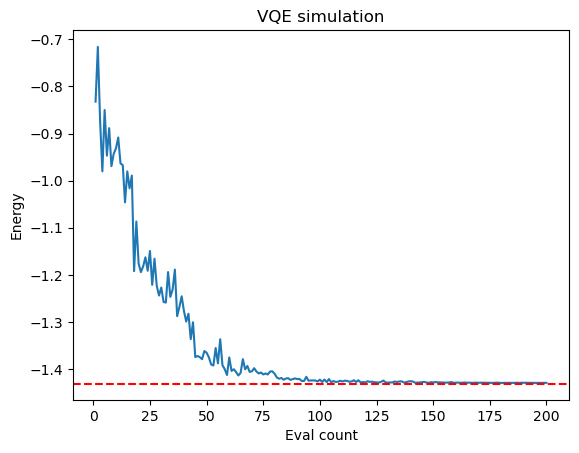

Step 8 - Energy : -1.1274401418111795 Ha
Step 16 - Energy : -1.2129017056225113 Ha
Step 24 - Energy : -1.2585016116280072 Ha
Step 32 - Energy : -1.2921691039124286 Ha
Step 40 - Energy : -1.3086374821651117 Ha
Step 48 - Energy : -1.3454784687762062 Ha
Step 56 - Energy : -1.3545355403110138 Ha
Step 64 - Energy : -1.3623450833221622 Ha
Step 72 - Energy : -1.361036450068198 Ha
Step 80 - Energy : -1.3637718251979787 Ha
Step 88 - Energy : -1.3639110090187958 Ha
Step 96 - Energy : -1.3645027572163002 Ha
Step 104 - Energy : -1.3644129780636065 Ha
Step 112 - Energy : -1.3653812559214098 Ha
Step 120 - Energy : -1.3652797570378032 Ha
Step 128 - Energy : -1.3655062084554395 Ha
Step 136 - Energy : -1.3656777952891284 Ha
Step 144 - Energy : -1.3657886987869745 Ha
Step 152 - Energy : -1.3657879971657616 Ha
Step 160 - Energy : -1.3658317393831514 Ha
Step 168 - Energy : -1.3658312365503718 Ha
Step 176 - Energy : -1.3658442537054585 Ha
Step 184 - Energy : -1.3658503953125807 Ha
Step 192 - Energy : -1.36

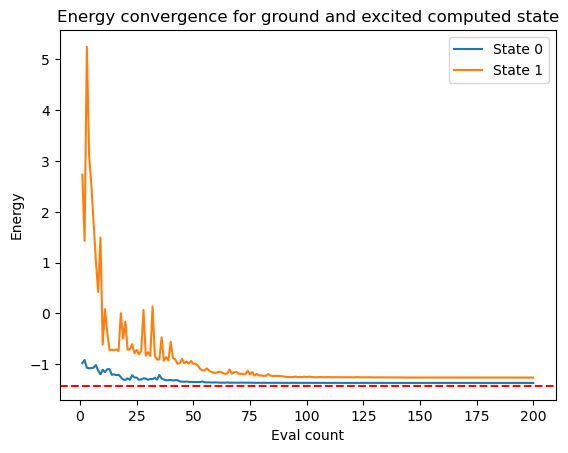


Reference values: [-1.43054631 -1.26040147]
VQD values: [-1.36587248 -1.26034693]


reference gap = 0.17014483729674668
vqd gap = 0.10552554240338075
Calculated gap = 0.1689572607449612
calculated gap is the energy difference between ground state(vqe) and first excited state(vqd)


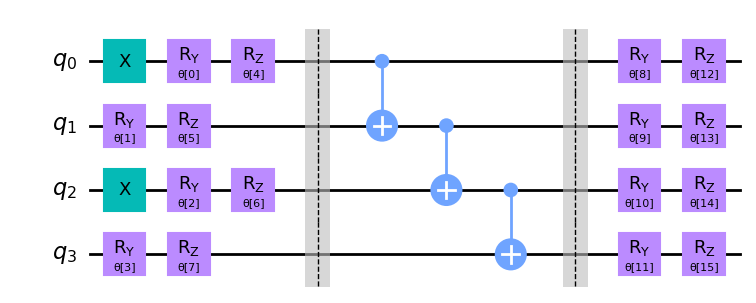

In [5]:
Bridging_the_Gap([["H", [0.0, 0.0, -0.6614]],["H",[0.0, 0.0, 0.6614]]],JordanWignerMapper(),'EfficientSU2', 'cobyla')